# Control Algorithm for a One-Dimensional Output Function (Gravity-Inspired Model)

I'm developing a control algorithm for a one-dimensional output function that processes a signal between 0 and 1. The output function is represented physically by a ball suspended in a vertical tube, where the ball is subject to gravity (downward acceleration).

The core of the algorithm allows for a force to be applied in the opposite direction, counteracting gravity. The goal is to compute the Y-position of the ball, which requires defining an acceleration function.

This system is modeled as a second-order ordinary differential equation (ODE), where:

    The position is the result of integrating the velocity.
    The velocity is derived by integrating the acceleration.

The second derivative of the ball's position is equal to a negative constant (representing downward gravity) plus a time-varying control function that allows for dynamic acceleration at specific moments.

In summary, the model simulates the ball’s vertical motion, influenced by constant gravity and modifiable by controlled forces. I'll be expanding on this model to create its software abstraction.

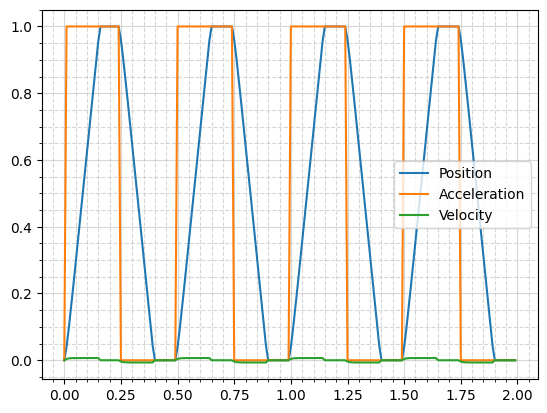

In [125]:
import numpy as np
import matplotlib.pyplot as plt

# Constants
GRAVITY = 1  # Acceleration due to gravity (m/s^2)
CEILING = 0.001
DAMPING = 0.6

class VerticalMotionControl:
    def __init__(self, initial_position=0.0, initial_velocity=0.0, time_step=0.01):
        self.position = initial_position  # Y position
        self.velocity = initial_velocity  # Y dot (velocity)
        self.time_step = time_step        # Time step (delta t)

    def compute_acceleration(self, external_acceleration):
        """
        Compute total acceleration (Y double dot).
        This includes gravity and any external acceleration applied at that time.
        """
        return GRAVITY * np.sign(external_acceleration)

    def update_velocity(self, acceleration):
        """
        Update the velocity by integrating the acceleration over the time step.
        """
        self.velocity += acceleration * self.time_step
        self.velocity *= (1 - DAMPING)
        return self.velocity

    def update_position(self):
        """
        Update the position by integrating the velocity over the time step.
        """
        self.position += self.velocity * self.time_step
        return self.position

    def simulate(self, acceleration_series):
        """
        Simulate the motion given a series of accelerations over time.
        Returns the position series and the corresponding time indices.
        """
        positions = []
        velocities = []
        time_indices = []

        for time_idx, external_acceleration in enumerate(acceleration_series):
            acceleration = self.compute_acceleration(external_acceleration)
            self.update_velocity(acceleration)
            self.update_position()

            if self.position < 0:
                self.position = 0
                self.velocity = 0

            if self.position > CEILING:
                self.position = CEILING
                self.velocity = 0

            positions.append(self.position)
            velocities.append(self.velocity)
            time_indices.append(time_idx * self.time_step)

        return time_indices, positions, velocities

# Example usage
if __name__ == "__main__":
    # Define the initial conditions and acceleration series
    initial_position = 0.0
    initial_velocity = 0.0
    time_step = 0.01
    total_time = 2  # Total simulation time in seconds
    time_points = int(total_time / time_step)

    # Example acceleration series cut off sine wave
    pulse_duration = 1
    pulse_frequency = 2/pulse_duration
    floor = 0.1
    acceleration_series = np.maximum(0, np.sin(2 * np.pi * pulse_frequency * np.linspace(0, total_time, time_points)))
    # Adjust the acceleration series based on the condition
    acceleration_series = np.where(acceleration_series > 0, 1, acceleration_series) - 0.5

    # Create an instance of the class and run the simulation
    control_system = VerticalMotionControl(initial_position, initial_velocity, time_step)
    time_indices, positions, velocities = control_system.simulate(acceleration_series)

    # Normalize the positions to be between 0 and 1
    positions = (positions - np.min(positions)) / (np.max(positions) - np.min(positions))

    # Normalize the acceleration series to be between 0 and 1
    acceleration_series = (acceleration_series - np.min(acceleration_series)) / (np.max(acceleration_series) - np.min(acceleration_series))

    # Plot the results (position and acceleration)
    plt.plot(time_indices, positions, label='Position')
    plt.plot(time_indices, acceleration_series, label='Acceleration')

    # Plot the velocity
    plt.plot(time_indices, velocities, label='Velocity')

    # Dash minor grid lines every 0.25 seconds
    plt.minorticks_on()
    plt.grid(which='minor', linestyle='--', alpha=0.5)
    plt.grid(which='major', alpha=0.5)
    plt.legend()
    plt.show()
